<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/tutorials/phy/0.089stddev_1000batches_variable_phasenoise_values_2_hidden_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

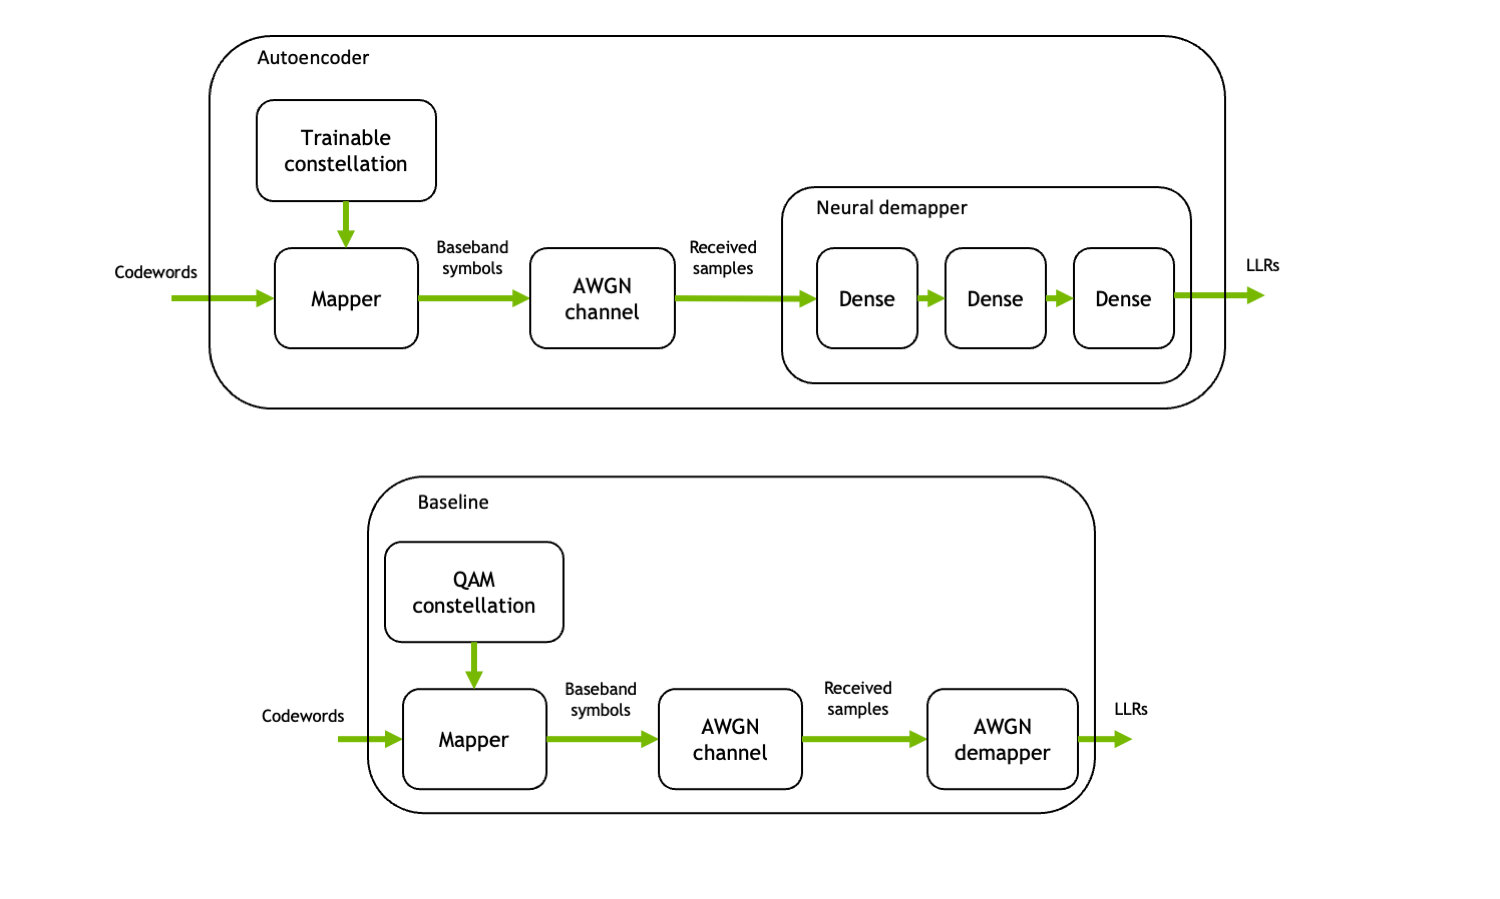


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [58]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [59]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.18.0


In [60]:
!pip install tensorflow-model-optimization

# Simulation Parameter

In [61]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 15

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_pruned = "awgn_autoencoder_weights_conventional_training_pruned" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

# Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

**Neural Demapper for AWGN Channel**

In [62]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [63]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [64]:
import tensorflow_model_optimization as tfmot

# Float32 demapper
float_demapper = create_functional_demapper_real_input(
    num_symbols_per_codeword, num_bits_per_symbol)

# QAT wrapper
qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



**Neural Demapper for (Phase Noise + AWGN) Channel**

In [65]:
# import tensorflow as tf
# from sionna.phy.utils import log10

# def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
#     """
#     Preprocess inputs for the phase noise demapper *without* internal preprocessing.
#     """
#     def log10_fn(x):
#         return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

#     batch_size = tf.shape(y)[0]
#     no = tf.convert_to_tensor(no, dtype=tf.float32)
#     sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)
#     no = tf.reshape(no, [-1, 1]) if len(no.shape) < 2 else no
#     sigma_phi = tf.reshape(sigma_phi, [-1, 1]) if len(sigma_phi.shape) < 2 else sigma_phi
#     no_db = log10_fn(no)
#     no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])
#     sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])
#     z = tf.stack([
#         tf.math.real(y),
#         tf.math.imag(y),
#         no_db_tiled,
#         sigma_phi_tiled
#     ], axis=2)
#     return z

In [66]:
def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
    batch_size = tf.shape(y)[0]
    no = tf.convert_to_tensor(no, dtype=tf.float32)
    sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)
    no_db = tf.math.log(no) / tf.math.log(tf.constant(10, dtype=tf.float32))
    no_db = tf.reshape(no_db, [-1, 1])  # shape [batch_size, 1]
    sigma_phi = tf.reshape(sigma_phi, [-1, 1])  # shape [batch_size, 1]
    no_db_tiled = tf.broadcast_to(no_db, [batch_size, num_symbols_per_codeword])
    sigma_phi_tiled = tf.broadcast_to(sigma_phi, [batch_size, num_symbols_per_codeword])
    z = tf.stack([
        tf.math.real(y),
        tf.math.imag(y),
        no_db_tiled,
        sigma_phi_tiled
    ], axis=2)
    return z


512 Neurones Demapper

In [67]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, units=512, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(units, activation='relu', name='dense1')(z_input)
    x = Dense(units, activation='relu', name='dense2')(x)  # Only 2 hidden layers now
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name=f"FunctionalDemapperPhaseNoise_{units}units_2layers")
    return model


In [68]:
float_demapper_phase_noise = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)

64 Neurones Demapper

In [69]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, units=64, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(units, activation='relu', name='dense1')(z_input)
    x = Dense(units, activation='relu', name='dense2')(x)  # Only 2 hidden layers now
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name=f"FunctionalDemapperPhaseNoise_{units}units_2layers")
    return model


32 Neurones Demapper

In [70]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, units=32, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(units, activation='relu', name='dense1')(z_input)
    x = Dense(units, activation='relu', name='dense2')(x)  # Only 2 hidden layers now
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name=f"FunctionalDemapperPhaseNoise_{units}units_2layers")
    return model



**Demapper Prunning**

In [71]:
pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}

In [72]:
def create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True):
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=pruning_params["initial_sparsity"],
        final_sparsity=pruning_params["final_sparsity"],
        begin_step=pruning_params["begin_step"],
        end_step=pruning_params["end_step"],
    )
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense1'), pruning_schedule=pruning_schedule)(z_input)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense2'), pruning_schedule=pruning_schedule)(x)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense3'), pruning_schedule=pruning_schedule)(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = prune_low_magnitude(Dense(output_units, activation=None, name='pruned_dense_out'), pruning_schedule=pruning_schedule)(x)
    model = Model(inputs=z_input, outputs=llr, name="PrunedFunctionalDemapperPhaseNoise")
    return model

**Phase Noise**

In [73]:
class PhaseNoise(Block):
    def __init__(self, *, precision=None, **kwargs):
        super().__init__(precision=precision, **kwargs)

    def call(self, x, sigma):
        phi = tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=1.0,
            dtype=self.rdtype
        )
        sigma = expand_to_rank(sigma, tf.rank(x), axis=-1)
        sigma = tf.cast(sigma, self.rdtype)
        phi *= sigma
        phase_rotation = tf.complex(tf.math.cos(phi), tf.math.sin(phi))
        return x * phase_rotation


**Phase Noise Gaussian**

In [74]:
class PhaseNoiseGaussian(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.complex64, name="phase_noise_gaussian", **kwargs):
        super().__init__(dtype=dtype, name=name, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
        self.start_phase_init = -1*np.pi
        self.start_phase_width = np.pi

    def call(self, inputs):
        print('*********Inside Gaussian Distributed PN************')
        x, sigma_phi = inputs
        var = 1.0
        var_dim = tf.cast(var, x.dtype.real_dtype)/tf.cast(2, x.dtype.real_dtype)
        stddev = tf.sqrt(var_dim)
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
        sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)
        sigma_phi = tf.cast(sigma_phi, self._real_dtype)
        noise *= tf.cast(sigma_phi, noise.dtype)
        pnr = tf.math.cos(noise)
        pni = tf.math.sin(noise)
        pn = tf.complex(pnr,pni)
        return x*pn

## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

**Diverse DataSet**

In [75]:
import tensorflow as tf
# ... (your other imports and Sionna setup code) ...

# Assuming your constants like num_bits_per_symbol, coderate, k, n,
# num_symbols_per_codeword, ebno_db_min, ebno_db_max, training_batch_size,
# num_training_iterations_conventional are already defined.

def gen_diverse():
    for _ in range(num_training_iterations_conventional):
        ebno_db = tf.random.uniform(
            shape=[training_batch_size],
            minval=ebno_db_min,
            maxval=ebno_db_max
        )
        # Randomly vary sigma_phi for training
        # Adjust minval and maxval for the range of phase noise you want to train for.
        # e.g., from very low phase noise to moderately high.
        sigma_phi_train = tf.random.uniform(
            shape=[training_batch_size, 1], # Shape must match usage in call method
            minval=0.0, # Start from very low phase noise
            maxval=0.4 # Example upper bound, adjust based on expected real-world scenarios
                       # 0.316 (variance 0.1) is within this range.
        )
        x = tf.zeros([training_batch_size, 1])
        yield x, ebno_db, sigma_phi_train # Yield sigma_phi_train

In [76]:
import tensorflow as tf

class DynamicBinarySource(tf.keras.layers.Layer):
    """Custom binary source layer supporting dynamic batch sizes"""
    def __init__(self, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)

    def call(self, shape):
        # shape: Tensor containing [batch_size, num_bits]
        u = tf.random.uniform(shape, minval=0, maxval=1, dtype=self.dtype)
        return tf.where(u < 0.5, 0.0, 1.0)

In [77]:
# Constants for evaluation phase noise (you can set different values for different BER plots)
DEFAULT_EVAL_PHASE_NOISE_VARIANCE = 0.089 # This corresponds to sigma_phi = sqrt(0.1) ~ 0.316
class E2ESystemConventionalTraining(tf.keras.Model):
    def __init__(self, training, use_pruning=False, pruning_params=None, pretrained_weights_path=None, demapper_type='512', name="e2e_system"):
        super().__init__(name=name)
        self._training = training
        self._use_pruning = use_pruning
        self._demapper_type = demapper_type  # Store demapper type
        # Transmitter - Use custom binary source
        self._binary_source = DynamicBinarySource(dtype=tf.float32)
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        qam_points = Constellation("qam", num_bits_per_symbol).points
        initial_points_r = tf.math.real(qam_points)
        initial_points_i = tf.math.imag(qam_points)

        self.points_r = self.add_weight(name='points_r', shape=initial_points_r.shape, initializer="zeros")
        self.points_i = self.add_weight(name='points_i', shape=initial_points_i.shape, initializer="zeros")
        self.points_r.assign(initial_points_r)
        self.points_i.assign(initial_points_i)

        points = tf.complex(self.points_r, self.points_i)
        self.constellation = Constellation("custom", num_bits_per_symbol, points=points, normalize=True, center=True)
        self._mapper = Mapper(constellation=self.constellation)

        # Channel
        self._phase_noise = PhaseNoiseGaussian(name="phase_noise")
        self._channel = AWGN()

        # Receiver - Updated to support different demapper types
        if self._use_pruning and pruning_params:
            self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, pruning_params, bitwise=True)
        else:
            if demapper_type == '512':
                self._demapper = create_functional_demapper_phase_noise_from_preprocessed(
                    num_bits_per_symbol, bitwise=True)
            elif demapper_type == '64':
                self._demapper = create_64_unit_functional_demapper_phase_noise_from_preprocessed(
                    num_bits_per_symbol, bitwise=True)
            elif demapper_type == '32':
                self._demapper = create_32_unit_functional_demapper_phase_noise_from_preprocessed(
                    num_bits_per_symbol, bitwise=True)
            else:
                raise ValueError(f"Unsupported demapper_type: {demapper_type}. Use '512', '64', or '32'.")

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)




    def call_with_intermediates(self, inputs, training=False):
        """SEPARATE method ONLY for visualization - does NOT affect training"""
        x, ebno_db = inputs
        batch_size = tf.shape(x)[0]

        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        # Generate data
        if self._training:
            shape = tf.stack([batch_size, n])
            c = self._binary_source(shape)
        else:
            shape = tf.stack([batch_size, k])
            b = self._binary_source(shape)
            c = self._encoder(b)

        # Clean constellation (after mapping)
        x_clean = self._mapper(c)

        # Stage 1: AWGN only (no phase noise)
        x_awgn_only = self._channel(x_clean, no)

        # Stage 2: Phase noise only (no AWGN)
        sigma_phi = tf.fill([batch_size, 1], 0.316)
        x_phase_only = self._phase_noise((x_clean, sigma_phi))

        # Stage 3: Joint impairment (phase noise + AWGN)
        x_joint = self._phase_noise((x_awgn_only, sigma_phi))

        return {
            'clean': x_clean,
            'awgn_only': x_awgn_only,
            'phase_only': x_phase_only,
            'joint': x_joint,
            'sigma_phi': sigma_phi,
            'no': no
        }

    def call(self, inputs, training=False,eval_sigma_phi=None):
        # Initialize batch_size to ensure it's always bound by Autograph.
        # This resolves UnboundLocalError by making the variable's existence explicit.
        batch_size = tf.constant(0, dtype=tf.int32) # Dummy initialization

        # Determine sigma_phi based on training vs. evaluation mode
        if training:
            # During training, inputs from generator will be (x, ebno_db, sigma_phi_train)
            x, ebno_db, sigma_phi_train = inputs
            sigma_phi = sigma_phi_train
        else:
            # During evaluation (sim_ber), inputs will be (x, ebno_db)
            x, ebno_db = inputs
            # Use the default evaluation phase noise variance
            sigma_phi = tf.fill([tf.shape(x)[0], 1], eval_sigma_phi if eval_sigma_phi is not None else DEFAULT_EVAL_PHASE_NOISE_VARIANCE)

       # Re-assign batch_size with the correct value after 'x' is defined
        batch_size = tf.shape(x)[0]
        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        # Use dynamic batch size with custom binary source
        if self._training:
            # Create shape tensor [batch_size, n]
            shape = tf.stack([batch_size, n])
            c = self._binary_source(shape)
        else:
            shape = tf.stack([batch_size, k])
            b = self._binary_source(shape)
            c = self._encoder(b)

        x = self._mapper(c)


        x_phase_noisy = self._phase_noise((x, sigma_phi))
        y = self._channel(x_phase_noisy, no)

        z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)
        llr = self._demapper(z)
        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])
            loss = self._bce(c_reshaped, llr)
            return loss
        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self(data, training=True)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return {"loss": loss}

A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [78]:
def print_pruned_layer_sparsity(layer):
    for weight in layer.weights:
        w = weight.numpy()
        sparsity = np.mean(w == 0)
        print(f"{layer.name} ({weight.name}): sparsity = {sparsity:.3f}")

def print_model_sparsity(model):
    for layer in model.layers:
        print_pruned_layer_sparsity(layer)

**Training Pipeline**

In [79]:

# 1. Build and train the conventional model
print("Training conventional model (512-unit demapper)...")
model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False,demapper_type='512')
model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

# Update data generator for training
data_gen_train = tf.data.Dataset.from_generator(
    gen_diverse, # Use the new diverse generator
    output_signature=(
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32) # Add sigma_phi_train
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)





model_conventional.fit(
    data_gen_train,
    epochs=1,
    verbose=2
)

model_conventional.save_weights('conventional_weights_512.h5')

# 2. Build and train the 64-unit model
# Use a new data generator for the 64-unit model

print("Training 64-unit model...")
model_64unit = E2ESystemConventionalTraining(
    training=True,
    use_pruning=False,
    demapper_type='64'
)
model_64unit.compile(optimizer=tf.keras.optimizers.Adam())



model_64unit.fit(data_gen_train, epochs=1, verbose=2)
model_64unit.save_weights('model_weights_64unit.h5')


# 3. Build and train the 32-unit model
print("Training 32-unit model...")
model_32unit = E2ESystemConventionalTraining(
    training=True,
    use_pruning=False,
    demapper_type='32'
)
model_32unit.compile(optimizer=tf.keras.optimizers.Adam())


model_32unit.fit(data_gen_train, epochs=1, verbose=2)
model_32unit.save_weights('model_weights_32unit.h5')



# 4. Build and train the pruned model (using 512-unit as base)

print("Training pruned model...")
model_pruned = E2ESystemConventionalTraining(
    training=True,
    use_pruning=True,
    pruning_params=pruning_params,
    demapper_type='512'  # Pruning only applied to 512-unit
)
model_pruned.compile(optimizer=tf.keras.optimizers.Adam())

# Build the model by calling it with a dummy input
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_pruned(dummy_input, training=False)

# model_pruned.load_weights('conventional_weights.h5', by_name=True, skip_mismatch=True)

pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_pruned')
]

model_pruned.fit(
    data_gen_train,
    epochs=1,
    callbacks=pruning_callbacks,
    verbose=2
)

# Print sparsity before stripping
print("\nPruned demapper sparsity BEFORE stripping:")
print_model_sparsity(model_pruned._demapper)

# Strip pruning
model_pruned._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned._demapper)

# Print sparsity after stripping
print("\nPruned demapper sparsity AFTER stripping:")
print_model_sparsity(model_pruned._demapper)

model_pruned.save_weights('model_weights_pruned.h5')


Training conventional model (512-unit demapper)...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 1980s - loss: 0.2397 - 1980s/epoch - 2s/step
Training 64-unit model...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 77s - loss: 0.2543 - 77s/epoch - 77ms/step
Training 32-unit model...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 39s - loss: 0.2390 - 39s/epoch - 39ms/step
Training pruned model...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 1955s - loss: 0.2505 - 1955s/epoch - 2s/step

Pruned demapper sparsity BEFORE stripping:
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/kernel:0): sparsity = 0.875
prune_low_magnitude_pruned_dense1 (prun

**Evaluation Pipeline**

In [80]:
# --- Evaluation Section ---

# First evaluation: with your original phase noise variance of 0.1
DEFAULT_EVAL_PHASE_NOISE_VARIANCE = 0.089 # This is sigma_phi, corresponds to variance 0.1
print(f"\n--- Evaluating models with Phase Noise Variance: {DEFAULT_EVAL_PHASE_NOISE_VARIANCE**2:.4f} ---")




# Load evaluation models (they will use DEFAULT_EVAL_PHASE_NOISE_VARIANCE internally)

# Conventional evaluation model
model_conventional_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='512'
)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))

model_conventional_eval(dummy_input, training=False)
model_conventional_eval.load_weights('conventional_weights_512.h5')

# 64-unit evaluation model
model_64unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='64'
)
model_64unit_eval(dummy_input, training=False)
model_64unit_eval.load_weights('model_weights_64unit.h5')

# 32-unit evaluation model
model_32unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='32'
)
model_32unit_eval(dummy_input, training=False)
model_32unit_eval.load_weights('model_weights_32unit.h5')



# Pruned evaluation model
model_pruned_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    pruning_params=pruning_params,
    demapper_type='512'
)
model_pruned_eval(dummy_input, training=False)
model_pruned_eval.load_weights('model_weights_pruned.h5')


--- Evaluating models with Phase Noise Variance: 0.0079 ---
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


In [81]:
model_conventional.get_weights()

[array([[-0.12807775,  0.0589571 ,  0.14771438, ...,  0.10939875,
          0.00901351,  0.11003304],
        [ 0.11298388,  0.0660027 , -0.17751098, ...,  0.0056928 ,
          0.00290483, -0.0459132 ],
        [ 0.10584286, -0.02181746, -0.08090966, ..., -0.06080896,
          0.0494551 , -0.05426852],
        [ 0.0051041 ,  0.11600523, -0.03646524, ..., -0.02210239,
          0.09591696,  0.0939071 ]], dtype=float32),
 array([ 1.26250118e-01,  1.11584984e-01,  2.02516802e-02, -4.76220883e-02,
        -5.01501048e-03,  1.50845110e-01, -3.16638052e-02,  4.84069027e-02,
         6.33913353e-02,  3.29787210e-02,  1.28122807e-01, -6.16160519e-02,
         9.08179730e-02,  1.71925314e-02, -1.59991592e-01, -3.77532914e-02,
        -1.51345301e-02, -5.64810671e-02, -1.26624964e-02,  7.38197640e-02,
        -3.86183001e-02, -9.35591683e-02, -5.44669777e-02, -1.25322668e-02,
        -1.42304851e-02, -4.91924696e-02, -6.08661249e-02,  4.78620753e-02,
        -3.90344150e-02,  1.93952937e-02,  

In [82]:
model_conventional.get_weights()

[array([[-0.12807775,  0.0589571 ,  0.14771438, ...,  0.10939875,
          0.00901351,  0.11003304],
        [ 0.11298388,  0.0660027 , -0.17751098, ...,  0.0056928 ,
          0.00290483, -0.0459132 ],
        [ 0.10584286, -0.02181746, -0.08090966, ..., -0.06080896,
          0.0494551 , -0.05426852],
        [ 0.0051041 ,  0.11600523, -0.03646524, ..., -0.02210239,
          0.09591696,  0.0939071 ]], dtype=float32),
 array([ 1.26250118e-01,  1.11584984e-01,  2.02516802e-02, -4.76220883e-02,
        -5.01501048e-03,  1.50845110e-01, -3.16638052e-02,  4.84069027e-02,
         6.33913353e-02,  3.29787210e-02,  1.28122807e-01, -6.16160519e-02,
         9.08179730e-02,  1.71925314e-02, -1.59991592e-01, -3.77532914e-02,
        -1.51345301e-02, -5.64810671e-02, -1.26624964e-02,  7.38197640e-02,
        -3.86183001e-02, -9.35591683e-02, -5.44669777e-02, -1.25322668e-02,
        -1.42304851e-02, -4.91924696e-02, -6.08661249e-02,  4.78620753e-02,
        -3.90344150e-02,  1.93952937e-02,  

In [83]:
model_pruned.get_weights()

[array([[-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.20817867,  0.18852654],
        [-0.30414268, -0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.30113167, -0.        ],
        [-0.        , -0.        ,  0.        , ...,  0.        ,
         -0.30367258, -0.23958986]], dtype=float32),
 array([ 2.00681165e-02, -2.13239552e-03,  1.03207186e-01, -1.63414311e-02,
         5.73153235e-02,  7.57694840e-02, -1.08449655e-02,  1.14871308e-01,
        -1.34112583e-02,  9.52781960e-02, -3.20443208e-03,  4.86268997e-02,
         1.06316976e-01,  8.74066900e-04,  5.32036200e-02,  2.72534825e-02,
         2.35210974e-02,  5.95382936e-02,  1.00834996e-01,  8.95961076e-02,
        -3.77517194e-02, -2.54144836e-02,  6.59137592e-02, -2.78999638e-02,
        -5.36742806e-02, -1.18146418e-02, -5.59188724e-02, -5.29940389e-02,
        -5.67742158e-03, -3.56037505e-02,  

**Post Training Quantization Pipeline**

In [84]:
def representative_data_gen():
    for _ in range(100):
        dummy_input = np.random.randn(1, num_symbols_per_codeword, 4).astype(np.float32)
        yield [dummy_input]

# Extract trained demapper from conventional model
demapper_model = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)
model_float = E2ESystemConventionalTraining(training=False)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_float(dummy_input, training=False)
model_float.load_weights('conventional_weights_512.h5')
demapper_model = model_float._demapper  # Should be a Keras model/layer

import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(demapper_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_quant_scale_range_check = True
tflite_quant_model = converter.convert()
with open("quantized_demapper.tflite", "wb") as f:
    f.write(tflite_quant_model)

class QuantizedDemapperWrapper(tf.keras.layers.Layer):
    def __init__(self, interpreter_path):
        super().__init__()
        self.interpreter = tf.lite.Interpreter(model_path=interpreter_path, num_threads=1)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def _wrapped_call_single(self, z_single):
        input_scale = self.input_details[0]['quantization'][0]
        input_zero_point = self.input_details[0]['quantization'][1]
        z_quant = np.round(z_single / input_scale + input_zero_point)
        z_quant = np.clip(z_quant, -128, 127).astype(np.int8)
        if z_quant.ndim == 2:
            z_quant = np.expand_dims(z_quant, axis=0)
        self.interpreter.set_tensor(self.input_details[0]['index'], z_quant)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        output_scale, output_zero_point = self.output_details[0]['quantization']
        output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
        return output_float[0]

    def call(self, z):
        return tf.map_fn(
            lambda x: tf.py_function(self._wrapped_call_single, [x], tf.float32),
            z,
            fn_output_signature=tf.TensorSpec(shape=(num_symbols_per_codeword, num_bits_per_symbol), dtype=tf.float32)
        )

# Plug quantized demapper into E2E model for evaluation
model_quantized = E2ESystemConventionalTraining(training=False)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_quantized(dummy_input, training=False)
model_quantized.load_weights('conventional_weights_512.h5')
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")



*********Inside Gaussian Distributed PN************


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


*********Inside Gaussian Distributed PN************


In [85]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_details = interpreter.get_input_details()
print(input_details[0]['dtype'])  # Should be np.float32 or np.uint8


<class 'numpy.int8'>


In [86]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="quantized_demapper.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]['dtype'])    # e.g., np.float32 or np.uint8
print("Output dtype:", output_details[0]['dtype'])  # e.g., np.float32 or np.uint8


Input dtype: <class 'numpy.int8'>
Output dtype: <class 'numpy.int8'>


## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [87]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [88]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [89]:
class ModelWrapper(tf.keras.Model):
    def __init__(self, base_model, ebno_db_value):
        super().__init__()
        self.base_model = base_model
        self.ebno_db_value = ebno_db_value  # fixed EbNo for evaluation

    def call(self, x):
        # x is input tensor of shape [batch_size, 1]
        batch_size = tf.shape(x)[0]
        ebno_db = tf.fill([batch_size], self.ebno_db_value)
        return self.base_model((x, ebno_db), training=False)


In [90]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi # Store evaluation sigma_phi

#     def call(self, inputs):
#         x, ebno_db = inputs
#         # Pass eval_sigma_phi to the underlying model's call method if it supports it
#         # Assuming your E2ESystemConventionalTraining's call method can accept a 3rd input
#         # when training=False, which overrides the DEFAULT_EVAL_PHASE_NOISE_VARIANCE.
#         # If not, the current setup relies on DEFAULT_EVAL_PHASE_NOISE_VARIANCE global/constant.
#         return self.model((x, ebno_db), training=False, eval_sigma_phi=self.eval_sigma_phi)

In [91]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, inputs, training=False, eval_sigma_phi=None):
#         # Use eval_sigma_phi from wrapper if not provided explicitly
#         eval_sigma_phi_to_pass = eval_sigma_phi if eval_sigma_phi is not None else self.eval_sigma_phi
#         # Forward inputs and keyword args to the wrapped model's call
#         return self.model(inputs, training=training, eval_sigma_phi=eval_sigma_phi_to_pass)


In [92]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, *inputs, training=False, eval_sigma_phi=None):
#         eval_sigma_phi_to_pass = eval_sigma_phi if eval_sigma_phi is not None else self.eval_sigma_phi
#         return self.model(*inputs, training=training, eval_sigma_phi=eval_sigma_phi_to_pass)


In [93]:
# import tensorflow as tf

# # Your existing E2ESystemConventionalTraining class and other helper functions
# # (e.g., DynamicBinarySource, PhaseNoiseGaussian, create_functional_demappers,
# # preprocess_complex_phase_noise_input, etc.) should remain as they are.

# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, inputs, training=False):
#         """
#         The 'call' method of the wrapper, designed to directly accept inputs
#         as provided by sim_ber during evaluation.

#         Args:
#             inputs: The primary inputs provided by sim_ber. For your E2ESystemConventionalTraining
#                     model in evaluation mode, this is expected to be a tuple `(x, ebno_db)`.
#             training: A boolean indicating if the model is in training mode.
#                       sim_ber will typically pass `False` for evaluation.
#         """
#         # Retrieve the fixed evaluation phase noise variance from the wrapper's initialization.
#         eval_sigma_phi_for_inner_model = self.eval_sigma_phi

#         # Call the wrapped model's 'call' method, forwarding all necessary arguments.
#         # Your E2ESystemConventionalTraining.call method expects:
#         # - `inputs` (which is the (x, ebno_db) tuple from sim_ber)
#         # - `training=False` (passed directly from sim_ber)
#         # - `eval_sigma_phi` (passed from the wrapper's stored value)
#         return self.model(inputs, training=training, eval_sigma_phi=eval_sigma_phi_for_inner_model)

In [94]:
# import tensorflow as tf

# # Your existing E2ESystemConventionalTraining class and other helper functions
# # should remain unchanged.

# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, x, ebno_db, training=False):
#         """
#         The 'call' method of the wrapper, designed to directly accept 'x' and 'ebno_db'
#         as separate positional arguments, as might be provided by sim_ber during evaluation.

#         Args:
#             x: The input data tensor (e.g., bits, symbols).
#             ebno_db: The Eb/No in dB tensor for the current batch.
#             training: A boolean indicating if the model is in training mode.
#                       sim_ber will typically pass `False` for evaluation.
#         """
#         # Construct the 'inputs' tuple that your inner E2ESystemConventionalTraining
#         # model's call method expects when `training=False`.
#         inputs_for_inner_model = (x, ebno_db)

#         # Retrieve the fixed evaluation phase noise variance from the wrapper's initialization.
#         eval_sigma_phi_for_inner_model = self.eval_sigma_phi

#         # Call the wrapped model's 'call' method, forwarding all necessary arguments.
#         # Your E2ESystemConventionalTraining.call method's signature is:
#         # `def call(self, inputs, training=False, eval_sigma_phi=None):`
#         return self.model(inputs_for_inner_model, training=training, eval_sigma_phi=eval_sigma_phi_for_inner_model)

In [95]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, inputs, training=False):
#         # Expect inputs to be a tuple: (x, ebno_db)
#         # Pass them as is to the inner model's call
#         return self.model(inputs, training=training, eval_sigma_phi=self.eval_sigma_phi)


In [96]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, *args, training=False, **kwargs):
#         print("SimberCompatibleWrapper called with", len(args), "args:", args)
#         # Accepts either (inputs,) or (x, ebno_db)
#         if len(args) == 1 and isinstance(args[0], (tuple, list)):
#             # Called as model((x, ebno_db))
#             inputs = args[0]
#         elif len(args) == 2:
#             # Called as model(x, ebno_db)
#             inputs = (args[0], args[1])
#         else:
#             raise ValueError("SimberCompatibleWrapper: Unexpected call signature.")
#         return self.model(inputs, training=training, eval_sigma_phi=self.eval_sigma_phi)


In [97]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, inputs, training=False):
#         # Forward call with extra eval_sigma_phi ONLY in inference mode
#         if training:
#             return self.model(inputs, training=True)
#         else:
#             return self.model(inputs, training=False, eval_sigma_phi=self.eval_sigma_phi)


In [98]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.eval_sigma_phi = eval_sigma_phi

#     def call(self, x, ebno_db, training=False):
#         return self.model((x, ebno_db), training=training, eval_sigma_phi=self.eval_sigma_phi)



In [99]:
# # The SimberCompatibleWrapper that correctly adapts to Sionna's sim_ber signature
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, model, k_val, eval_sigma_phi=None):
#         super().__init__()
#         self.model = model
#         self.k = k_val
#         self.eval_sigma_phi = eval_sigma_phi
#         self._binary_source = DynamicBinarySource(dtype=tf.float32)

#     def call(self, batch_size_simber, ebno_db_simber):
#         # Generate the dummy 'x' input that the wrapped model expects
#         x_input_bits = self._binary_source(tf.stack([batch_size_simber, self.k]))

#         # Form the `inputs` tuple for the wrapped model's `call` method
#         inputs_for_wrapped_model = (x_input_bits, ebno_db_simber)

#         # Call the wrapped model, passing `training=False` and `eval_sigma_phi`
#         return self.model(inputs_for_wrapped_model, training=False, eval_sigma_phi=self.eval_sigma_phi)

In [100]:
class SimberCompatibleWrapper(tf.keras.Model):
    def __init__(self, model, k_val, eval_sigma_phi=None):
        super().__init__()
        self.model = model
        self.k = k_val
        self.eval_sigma_phi = eval_sigma_phi
        self._binary_source = DynamicBinarySource(dtype=tf.float32)

    def call(self, batch_size_simber, ebno_db_simber):
        # Generate the dummy 'x' input that the wrapped model expects
        x_input_bits = self._binary_source(tf.stack([batch_size_simber, self.k]))

        # --- CHANGE THIS LINE ---
        # Form the `inputs` as a LIST for the wrapped model's `call` method
        inputs_for_wrapped_model = [x_input_bits, ebno_db_simber]
        # --- END CHANGE ---

        # Call the wrapped model, passing `training=False` and `eval_sigma_phi`
        return self.model(inputs_for_wrapped_model, training=False, eval_sigma_phi=self.eval_sigma_phi)

In [101]:
# def make_mc_fun(model_eval):
#     def mc_fun(batch_size, ebno_db):
#         # Create dummy input (not used, but required by your model)
#         x = tf.zeros([batch_size, 1], dtype=tf.float32)
#         # Call the model, which generates its own bits internally
#         b, b_hat = model_eval((x, ebno_db))
#         return b, b_hat
#     return mc_fun


In [102]:
# def make_mc_fun(model, k):
#     """
#     Returns a callable mc_fun(batch_size, ebno_db) compatible with sim_ber(),
#     for the given model and block length k.

#     Parameters:
#         model: A tf.keras.Model instance accepting (b, ebno_db) as input.
#         k: Block length (number of bits)
#     """
#     def mc_fun(batch_size, ebno_db):
#         # Generate random input bits
#         b = tf.random.uniform(shape=(batch_size, k), minval=0, maxval=2, dtype=tf.int32)
#         b_float = tf.cast(b, tf.float32)

#         # Broadcast Eb/No
#         ebno_tensor = tf.ones((batch_size, 1), dtype=tf.float32) * ebno_db

#         # Forward pass through the model
#         b_out, b_hat = model((b_float, ebno_tensor), training=False)

#         return b, b_hat

#     return mc_fun



In [103]:
sigma_phi = 0.2236  # sqrt(0.05)


In [104]:
def make_mc_fun(model_eval):
    def mc_fun(batch_size, ebno_db):
        # Create dummy input (not used, but required by your model)
        x = tf.zeros([batch_size, 1], dtype=tf.float32)
        #x_dummy_input = tf.zeros([batch_size, k], dtype=tf.float32)
        # Call the model, which generates its own bits internally
        b, b_hat = model_eval((  x, ebno_db))
        #b, b_hat = model_eval(x_dummy_input, ebno_db)
        return b, b_hat
    return mc_fun


In [105]:

# Dictionary storing the results
BER = {}

model_baseline = Baseline() # Re-instantiate or ensure it's built to match sim_ber signature
# No wrapper needed for baseline if its call matches sim_ber directly
ber_baseline, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode= "xla")
BER['baseline'] = ber_baseline.numpy()

mc_fun_conventional = make_mc_fun(model_conventional_eval)
ber_conventional, _ = sim_ber(mc_fun_conventional, ebno_dbs, batch_size=128,
                               num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-conv-pn0.1'] = ber_conventional.numpy()

# For the 64-unit model
mc_fun_64 = make_mc_fun(model_64unit_eval)
ber_64, _ = sim_ber(mc_fun_64, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-64unit-pn0.1'] = ber_64.numpy()

# For the 32-unit model
mc_fun_32 = make_mc_fun(model_32unit_eval)
ber_32, _ = sim_ber(mc_fun_32, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-32unit-pn0.1'] = ber_32.numpy()

# For the pruned model
mc_fun_pruned = make_mc_fun(model_pruned_eval)
ber_pruned, _ = sim_ber(mc_fun_pruned, ebno_dbs, batch_size=128,
                        num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-pruned-pn0.1'] = ber_pruned.numpy()

# For the quantized model
mc_fun_quantized = make_mc_fun(model_quantized)
ber_quantized, _ = sim_ber(mc_fun_quantized, ebno_dbs, batch_size=128,
                           num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-quantized-pn0.1'] = ber_quantized.numpy()


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2274e-01 | 1.0000e+00 |       94265 |      768000 |         1024 |        1024 |         9.7 |reached target block errors
      4.5 | 9.6204e-02 | 9.9707e-01 |       73885 |      768000 |         1021 |        1024 |         4.5 |reached target block errors
      5.0 | 5.9363e-02 | 9.2361e-01 |       51290 |      864000 |         1064 |        1152 |         6.0 |reached target block errors
      5.5 | 1.9085e-02 | 5.2135e-01 |       27483 |     1440000 |         1001 |        1920 |         8.2 |reached target block errors
      6.0 | 2.5012e-03 | 1.1379e-01 |       16568 |     6624000 |         1005 |        8832 |        40.9 |reached target block errors
      6.5 | 1.1552e-04 | 9.2187e-03 |        1109 |     9600000 |

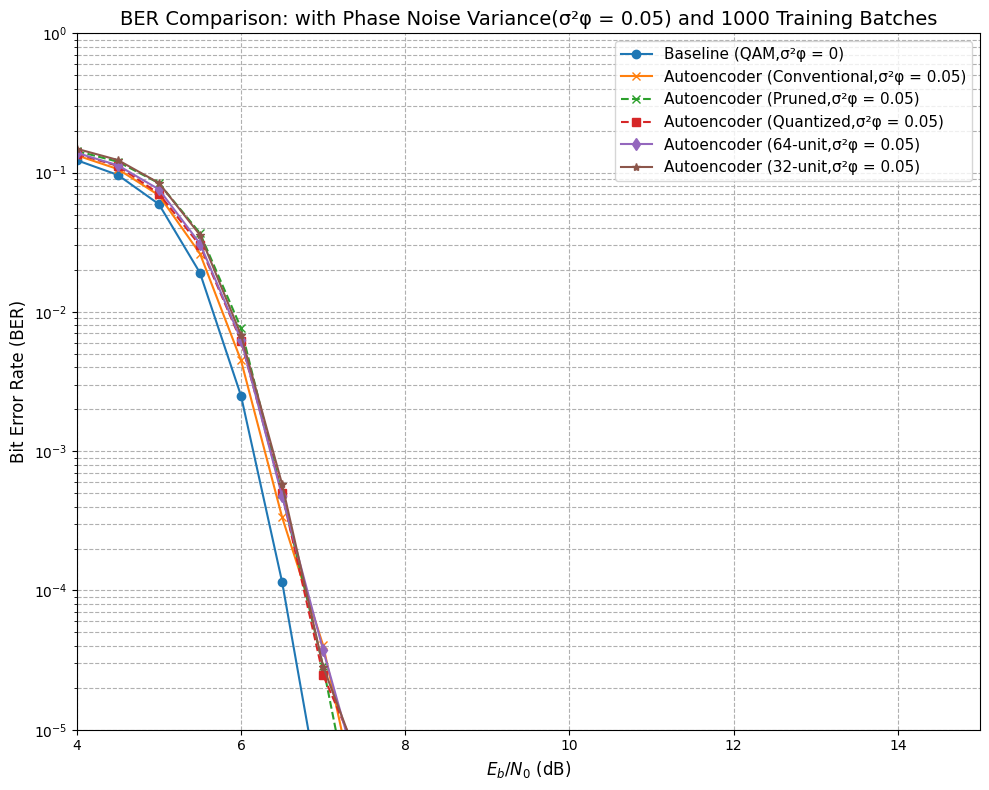

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Baseline (e.g., QAM)
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label='Baseline (QAM,σ²φ = 0)')

# Autoencoder (conventional training)
plt.semilogy(ebno_dbs, BER['autoencoder-conv-pn0.1'], 'x-', color='C1', label='Autoencoder (Conventional,σ²φ = 0.05)')

# Autoencoder (QAT-trained)
plt.semilogy(ebno_dbs, BER['autoencoder-pruned-pn0.1'], 'x--', color='C2', label='Autoencoder (Pruned,σ²φ = 0.05)')

# Autoencoder (Post-Training Quantized)
plt.semilogy(ebno_dbs, BER['autoencoder-quantized-pn0.1'], 's--', color='C3', label='Autoencoder (Quantized,σ²φ = 0.05)')

# Update your plot to include the 64-unit results
plt.semilogy(ebno_dbs, BER['autoencoder-64unit-pn0.1'], 'd-', color='C4', label='Autoencoder (64-unit,σ²φ = 0.05)')

# Update your plot to include the 32-unit results
plt.semilogy(ebno_dbs, BER['autoencoder-32unit-pn0.1'], '*-', color='C5', label='Autoencoder (32-unit,σ²φ = 0.05)')

plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title("BER Comparison: with Phase Noise Variance(σ²φ = 0.05) and 1000 Training Batches", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.8)
plt.ylim((1e-5, 1.0))
plt.xlim((ebno_db_min, ebno_db_max))
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [107]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))

# # Baseline (e.g., QAM)
# plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label='Baseline (QAM)')

# # Autoencoder (conventional training)
# plt.semilogy(ebno_dbs, BER['autoencoder-conv-pn0.5'], 'x-', color='C1', label='Autoencoder (Conventional)')

# # Autoencoder (QAT-trained)
# plt.semilogy(ebno_dbs, BER['autoencoder-pruned-pn0.5'], 'x--', color='C2', label='Autoencoder (Pruned)')

# # Autoencoder (Post-Training Quantized)
# plt.semilogy(ebno_dbs, BER['autoencoder-quantized-pn0.5'], 's--', color='C3', label='Autoencoder (Quantized)')

# # Update your plot to include the 64-unit results
# plt.semilogy(ebno_dbs, BER['autoencoder-64unit-pn0.5'], 'd-', color='C4', label='Autoencoder (64-unit)')

# # Update your plot to include the 32-unit results
# plt.semilogy(ebno_dbs, BER['autoencoder-32unit-pn0.5'], '*-', color='C5', label='Autoencoder (32-unit)')

# plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
# plt.ylabel("Bit Error Rate (BER)", fontsize=12)
# plt.title("BER Comparison: with Phase Noise Variance of 0.05 and 5000 Training Batches", fontsize=14)
# plt.grid(True, which="both", linestyle='--', linewidth=0.8)
# plt.ylim((1e-5, 1.0))
# plt.xlim((ebno_db_min, ebno_db_max))
# plt.legend(fontsize=11)
# plt.tight_layout()
# plt.show()


In [108]:
print("Quantized model evaluation:")
for layer in model_quantized.layers:
    print(layer.__class__.__name__)


Quantized model evaluation:
DynamicBinarySource
PhaseNoiseGaussian
QuantizedDemapperWrapper


## Visualizing the Learned Constellations

In [109]:
def plot_constellation(model, title):
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points
    fig = model.constellation.show()
    fig.suptitle(title)
    return fig




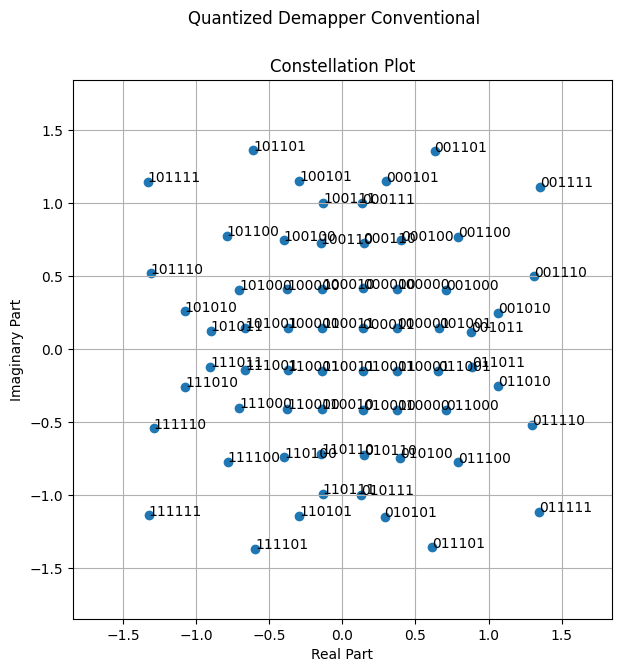

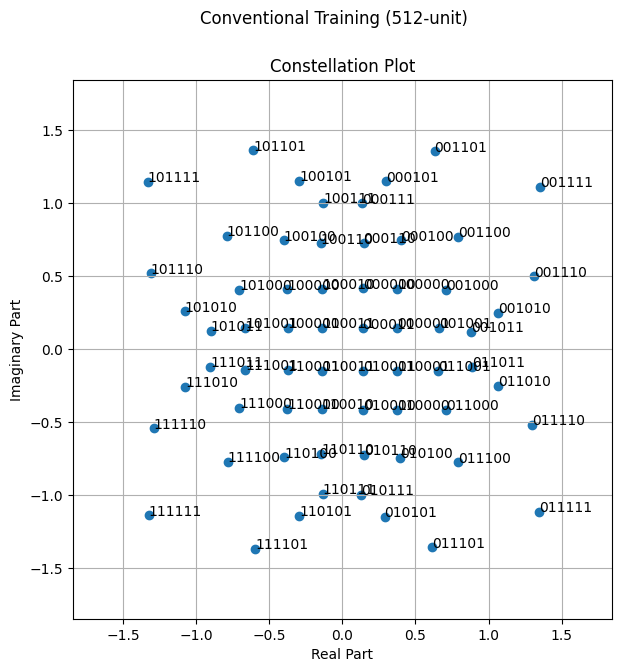

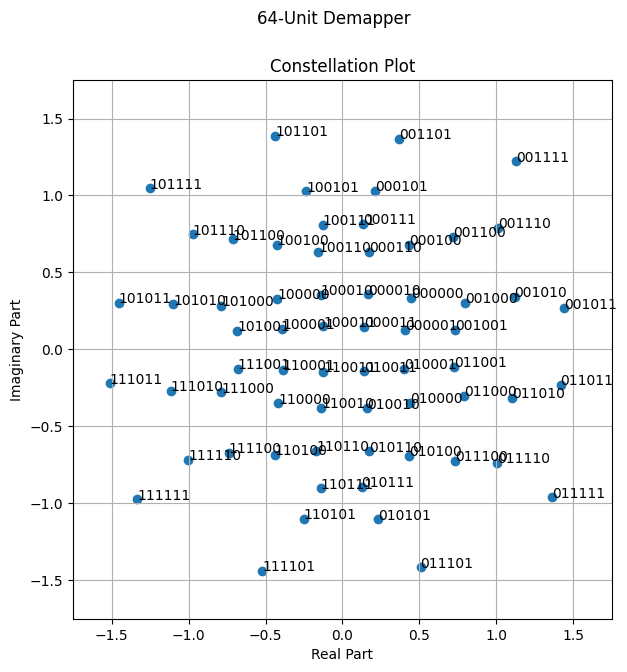

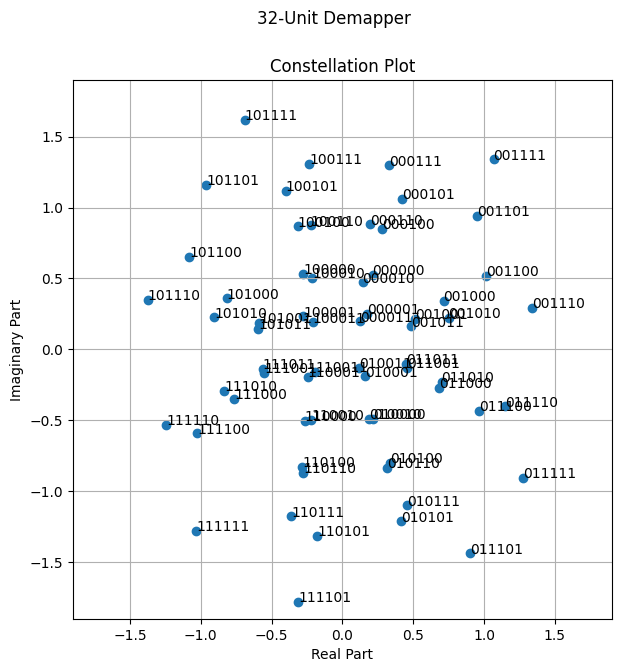

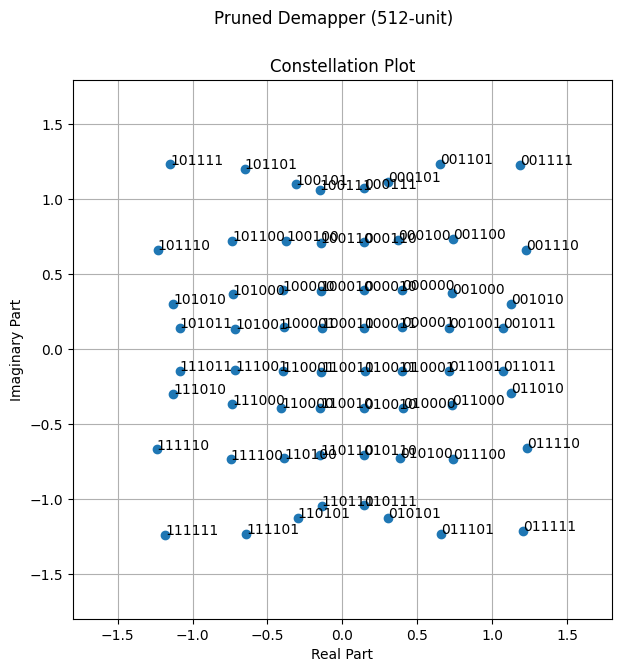

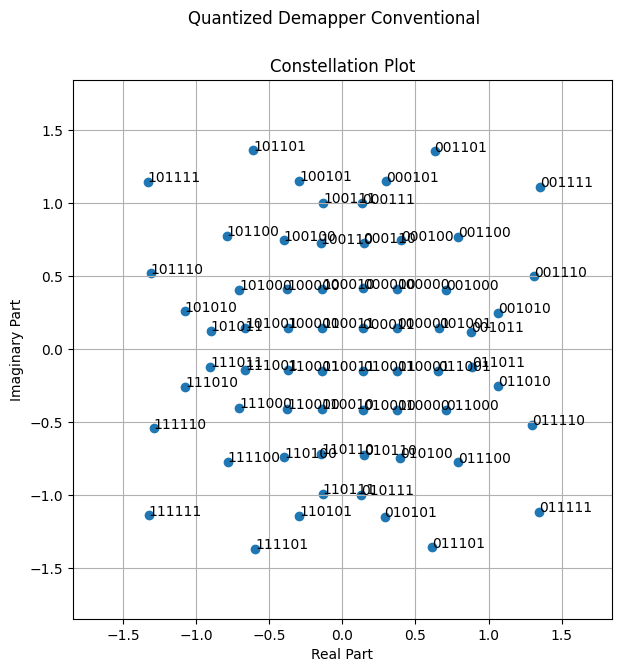

In [110]:
# Plot for 512-unit (conventional) model
plot_constellation(model_conventional_eval, "Conventional Training (512-unit)")

# Plot for 64-unit model
plot_constellation(model_64unit_eval, "64-Unit Demapper")

# Plot for 32-unit model
plot_constellation(model_32unit_eval, "32-Unit Demapper")

# Plot for pruned model (512-unit)
plot_constellation(model_pruned_eval, "Pruned Demapper (512-unit)")

# Plot for quantized model
plot_constellation(model_quantized, "Quantized Demapper Conventional")


**Phase noise + AWGN Impairment**

In [111]:
def plot_constellation_stages(model, ebno_db=8, num_samples=1000, title_prefix=""):
    """Plot constellation at different stages: AWGN only, Phase noise only, Joint"""

    # Generate test data
    test_input = (tf.zeros([num_samples, 1]), tf.fill([num_samples], ebno_db))

    # Get intermediate outputs
    intermediates = model.call_with_intermediates(test_input, training=False)

    # Extract constellation points
    x_awgn_only = intermediates['awgn_only'].numpy()
    x_phase_only = intermediates['phase_only'].numpy()
    x_joint = intermediates['joint'].numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: AWGN only
    axes[0].scatter(x_awgn_only.real, x_awgn_only.imag, alpha=0.6, s=10, color='blue')
    axes[0].set_title(f'{title_prefix}AWGN Only\n(Amplitude-dependent noise)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Imaginary')
    axes[0].axis('equal')

    # Plot 2: Phase noise only
    axes[1].scatter(x_phase_only.real, x_phase_only.imag, alpha=0.6, s=10, color='orange')
    axes[1].set_title(f'{title_prefix}Phase Noise Only\n(Angular noise, σ²φ = 0.1)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlabel('Real')
    axes[1].set_ylabel('Imaginary')
    axes[1].axis('equal')

    # Plot 3: Joint impairment
    axes[2].scatter(x_joint.real, x_joint.imag, alpha=0.6, s=10, color='red')
    axes[2].set_title(f'{title_prefix}Joint Impairment\n(Phase Noise + AWGN, Eb/N0={ebno_db}dB)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlabel('Real')
    axes[2].set_ylabel('Imaginary')
    axes[2].axis('equal')

    plt.tight_layout()
    plt.show()

    return fig


In [112]:
def plot_multi_model_comparison(models_dict, ebno_db=8, num_samples=1000):
    """Compare multiple models side by side"""

    n_models = len(models_dict)
    fig, axes = plt.subplots(n_models, 3, figsize=(15, 5*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for i, (model_name, model) in enumerate(models_dict.items()):
        # Generate test data
        test_input = (tf.zeros([num_samples, 1]), tf.fill([num_samples], ebno_db))
        intermediates = model.call_with_intermediates(test_input, training=False)

        x_awgn_only = intermediates['awgn_only'].numpy()
        x_phase_only = intermediates['phase_only'].numpy()
        x_joint = intermediates['joint'].numpy()

        # Plot AWGN only
        axes[i, 0].scatter(x_awgn_only.real, x_awgn_only.imag, alpha=0.6, s=10, color='blue')
        axes[i, 0].set_title(f'{model_name}: AWGN Only')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].axis('equal')

        # Plot phase noise only
        axes[i, 1].scatter(x_phase_only.real, x_phase_only.imag, alpha=0.6, s=10, color='orange')
        axes[i, 1].set_title(f'{model_name}: Phase Noise Only')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].axis('equal')

        # Plot joint impairment
        axes[i, 2].scatter(x_joint.real, x_joint.imag, alpha=0.6, s=10, color='red')
        axes[i, 2].set_title(f'{model_name}: Joint Impairment')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].axis('equal')

    plt.tight_layout()
    plt.show()
    return fig


Plotting constellation stages...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


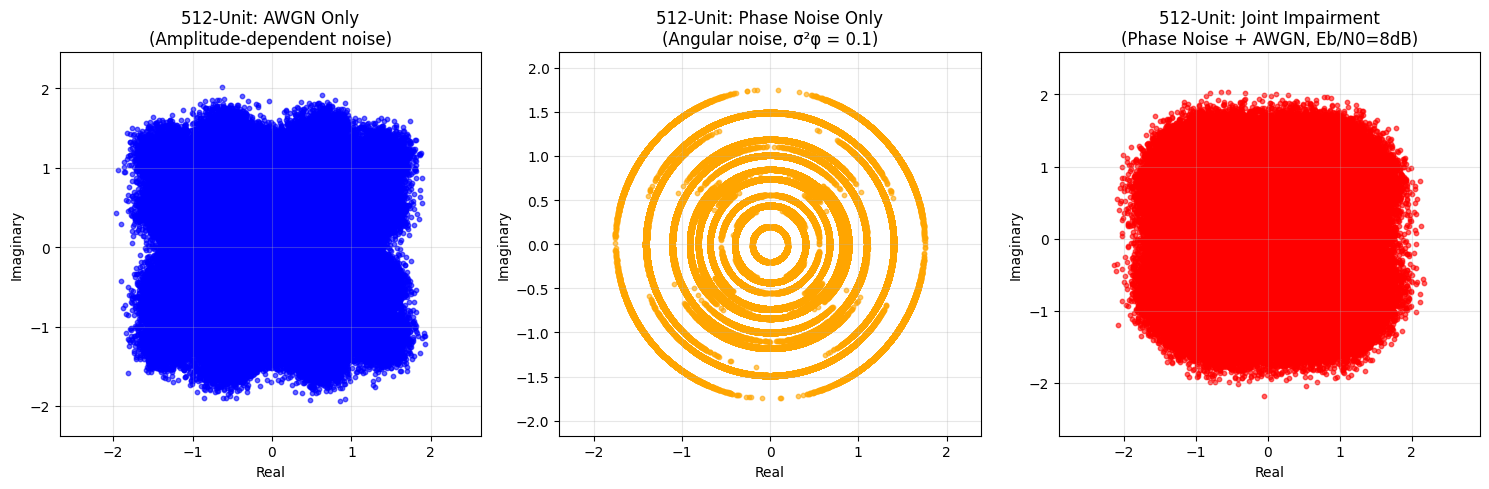

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


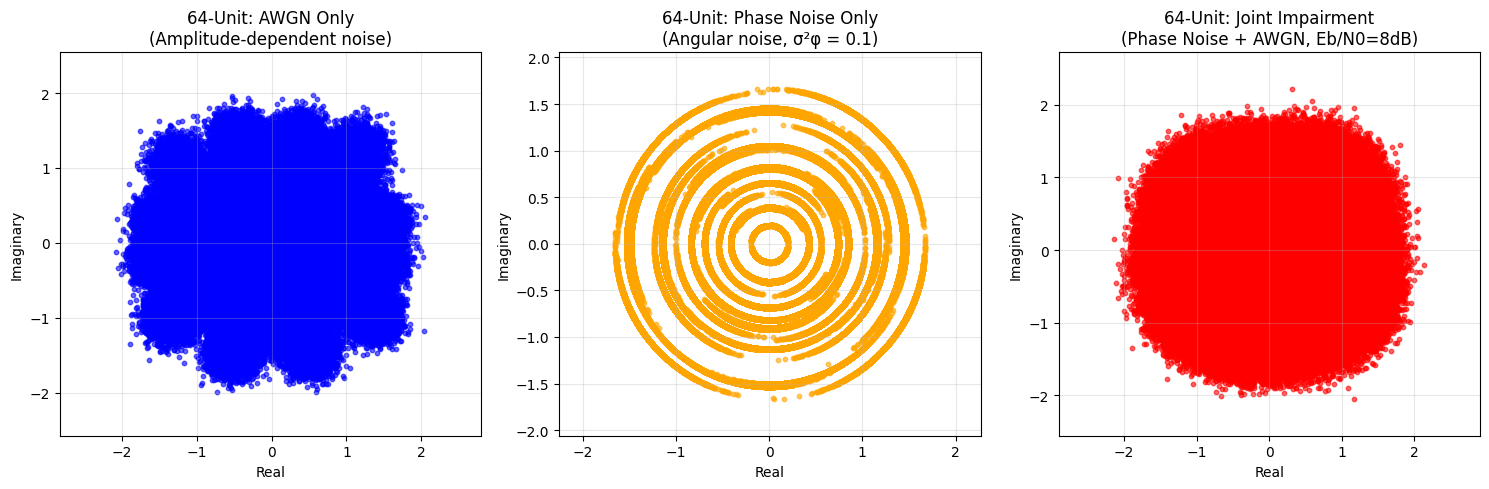

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


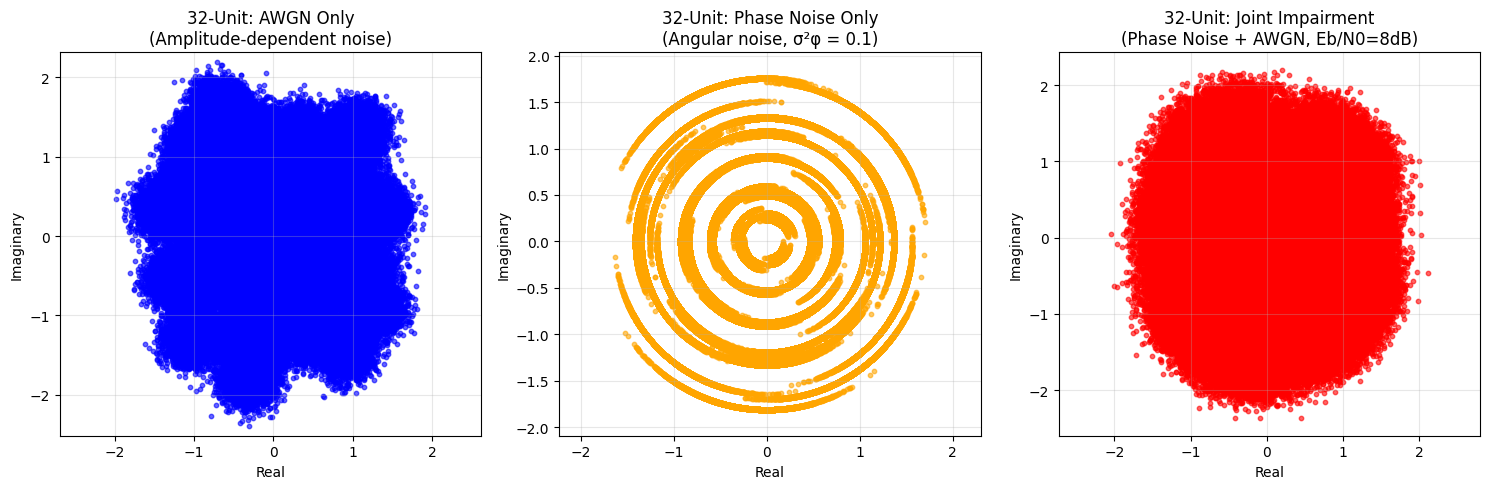

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


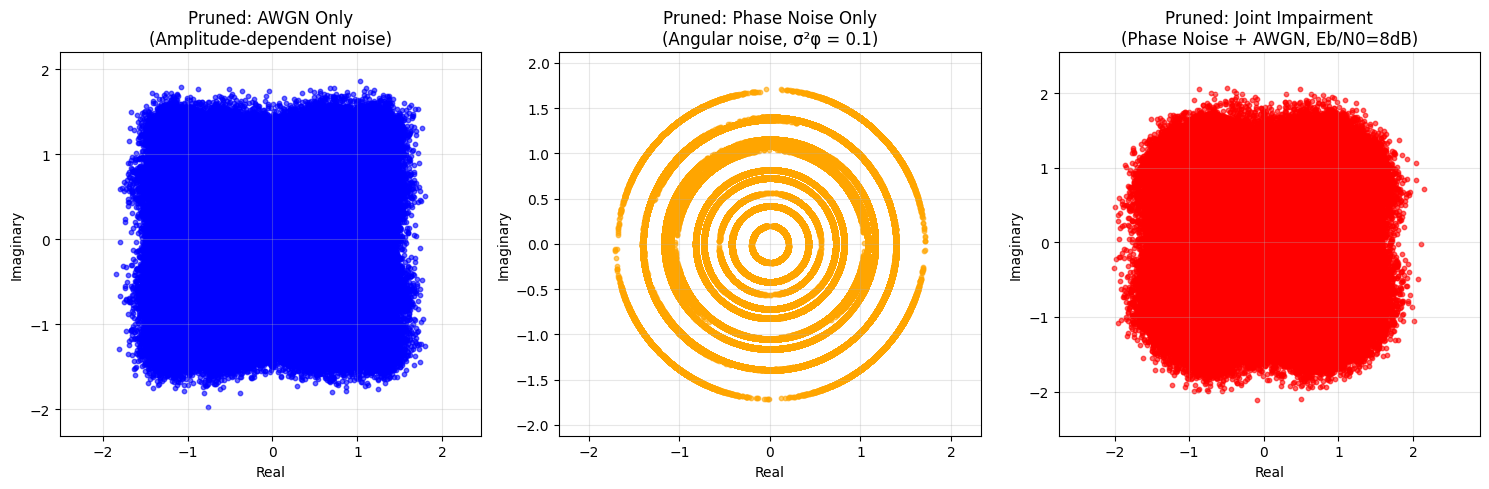

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


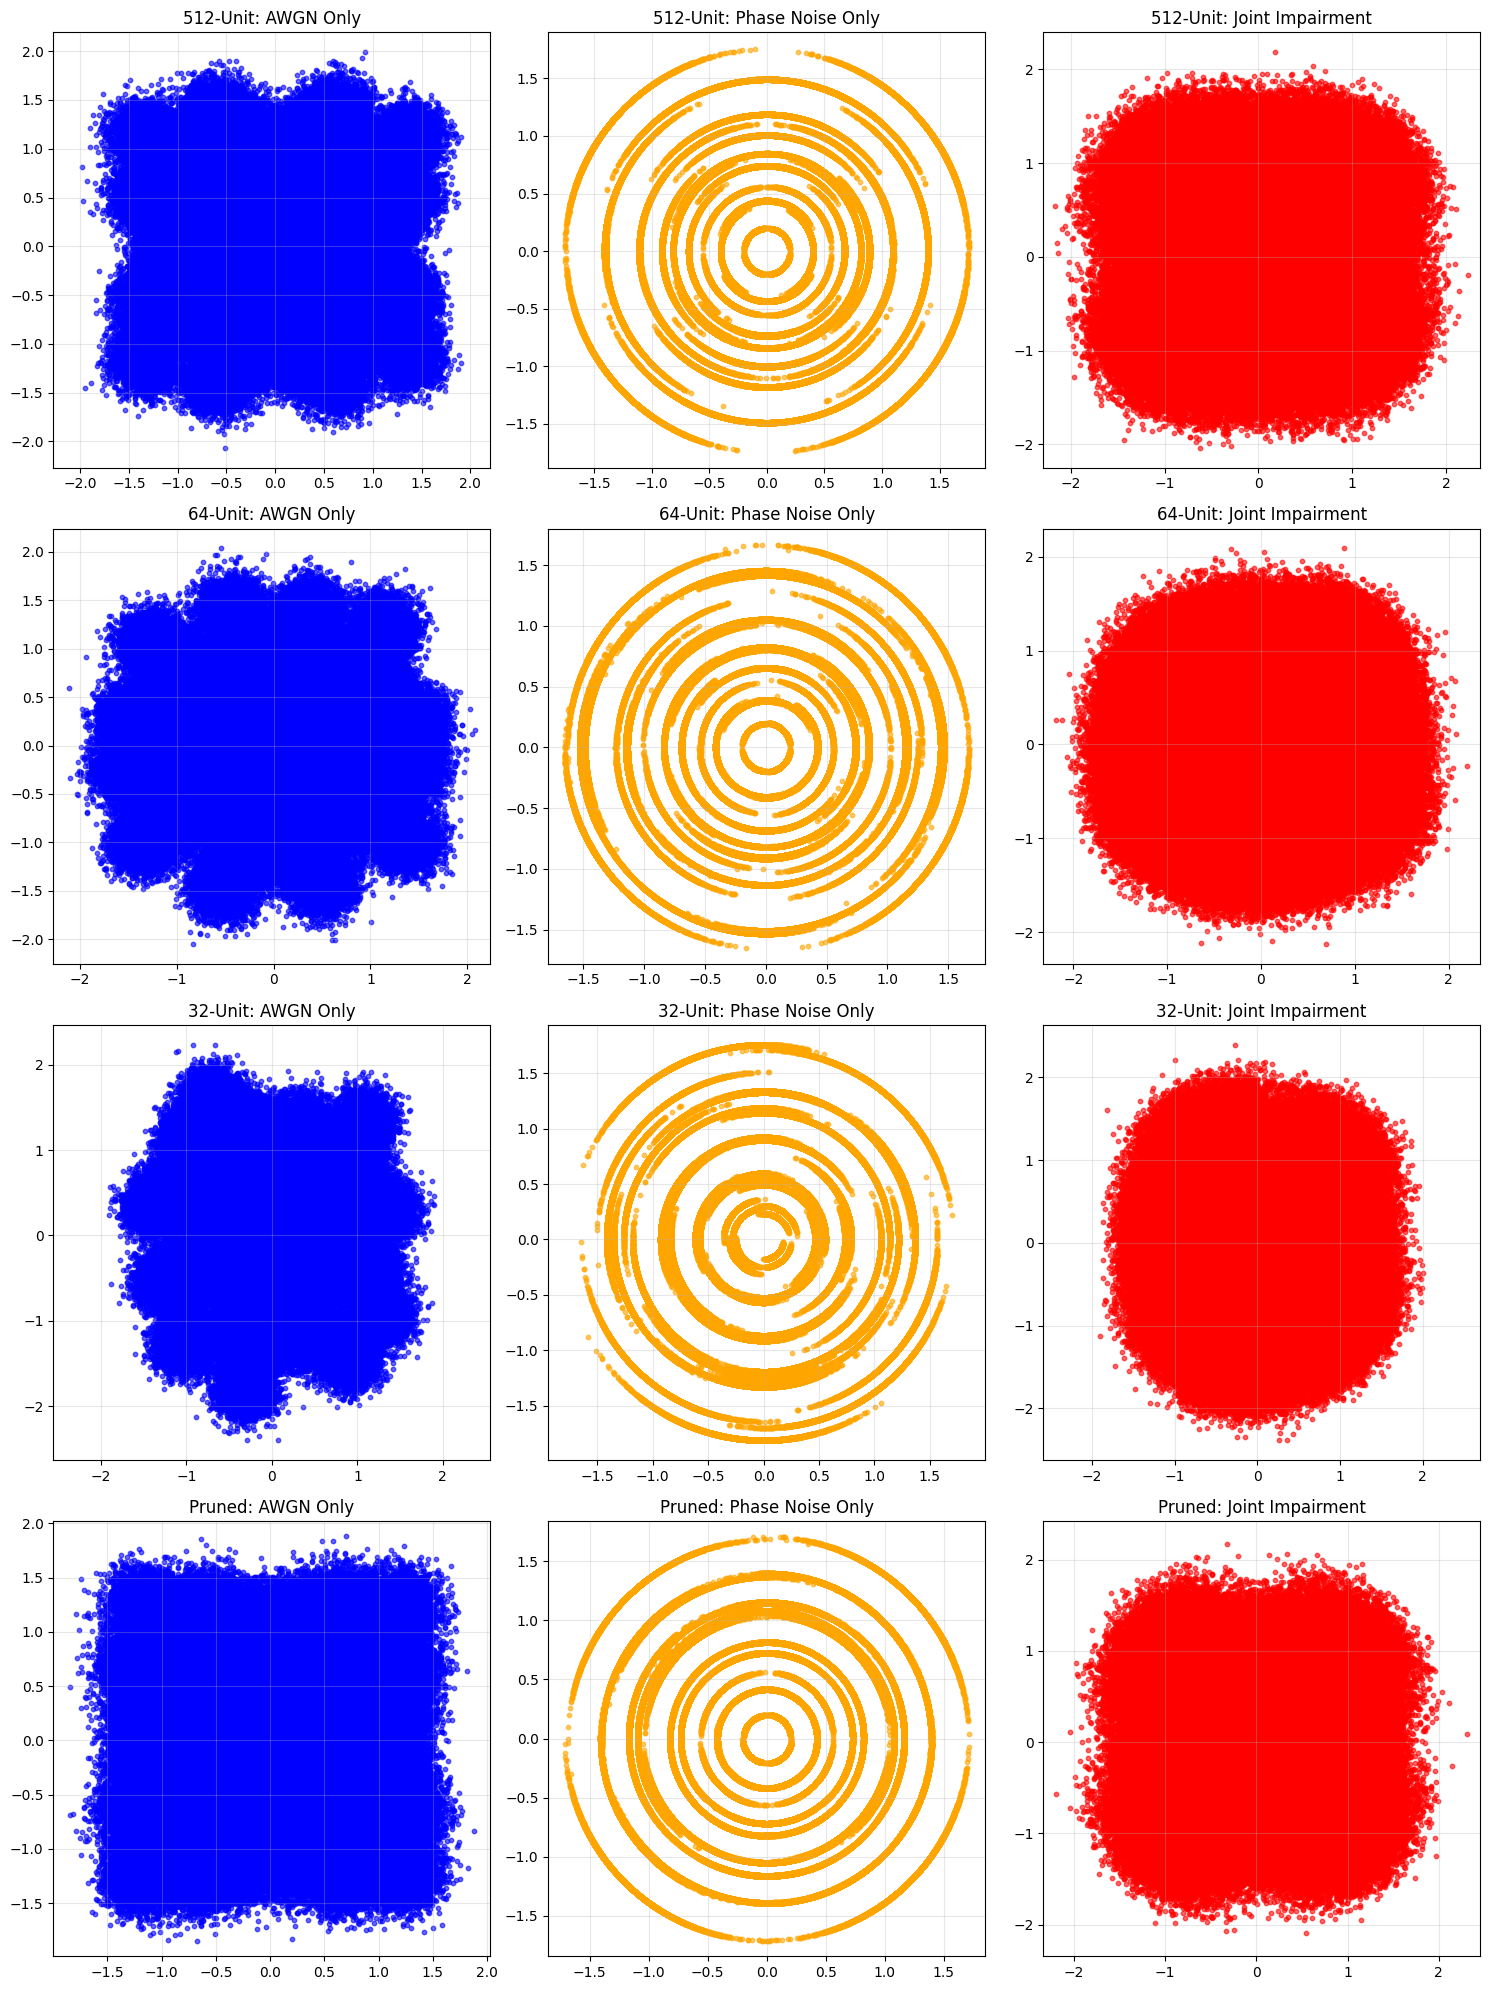

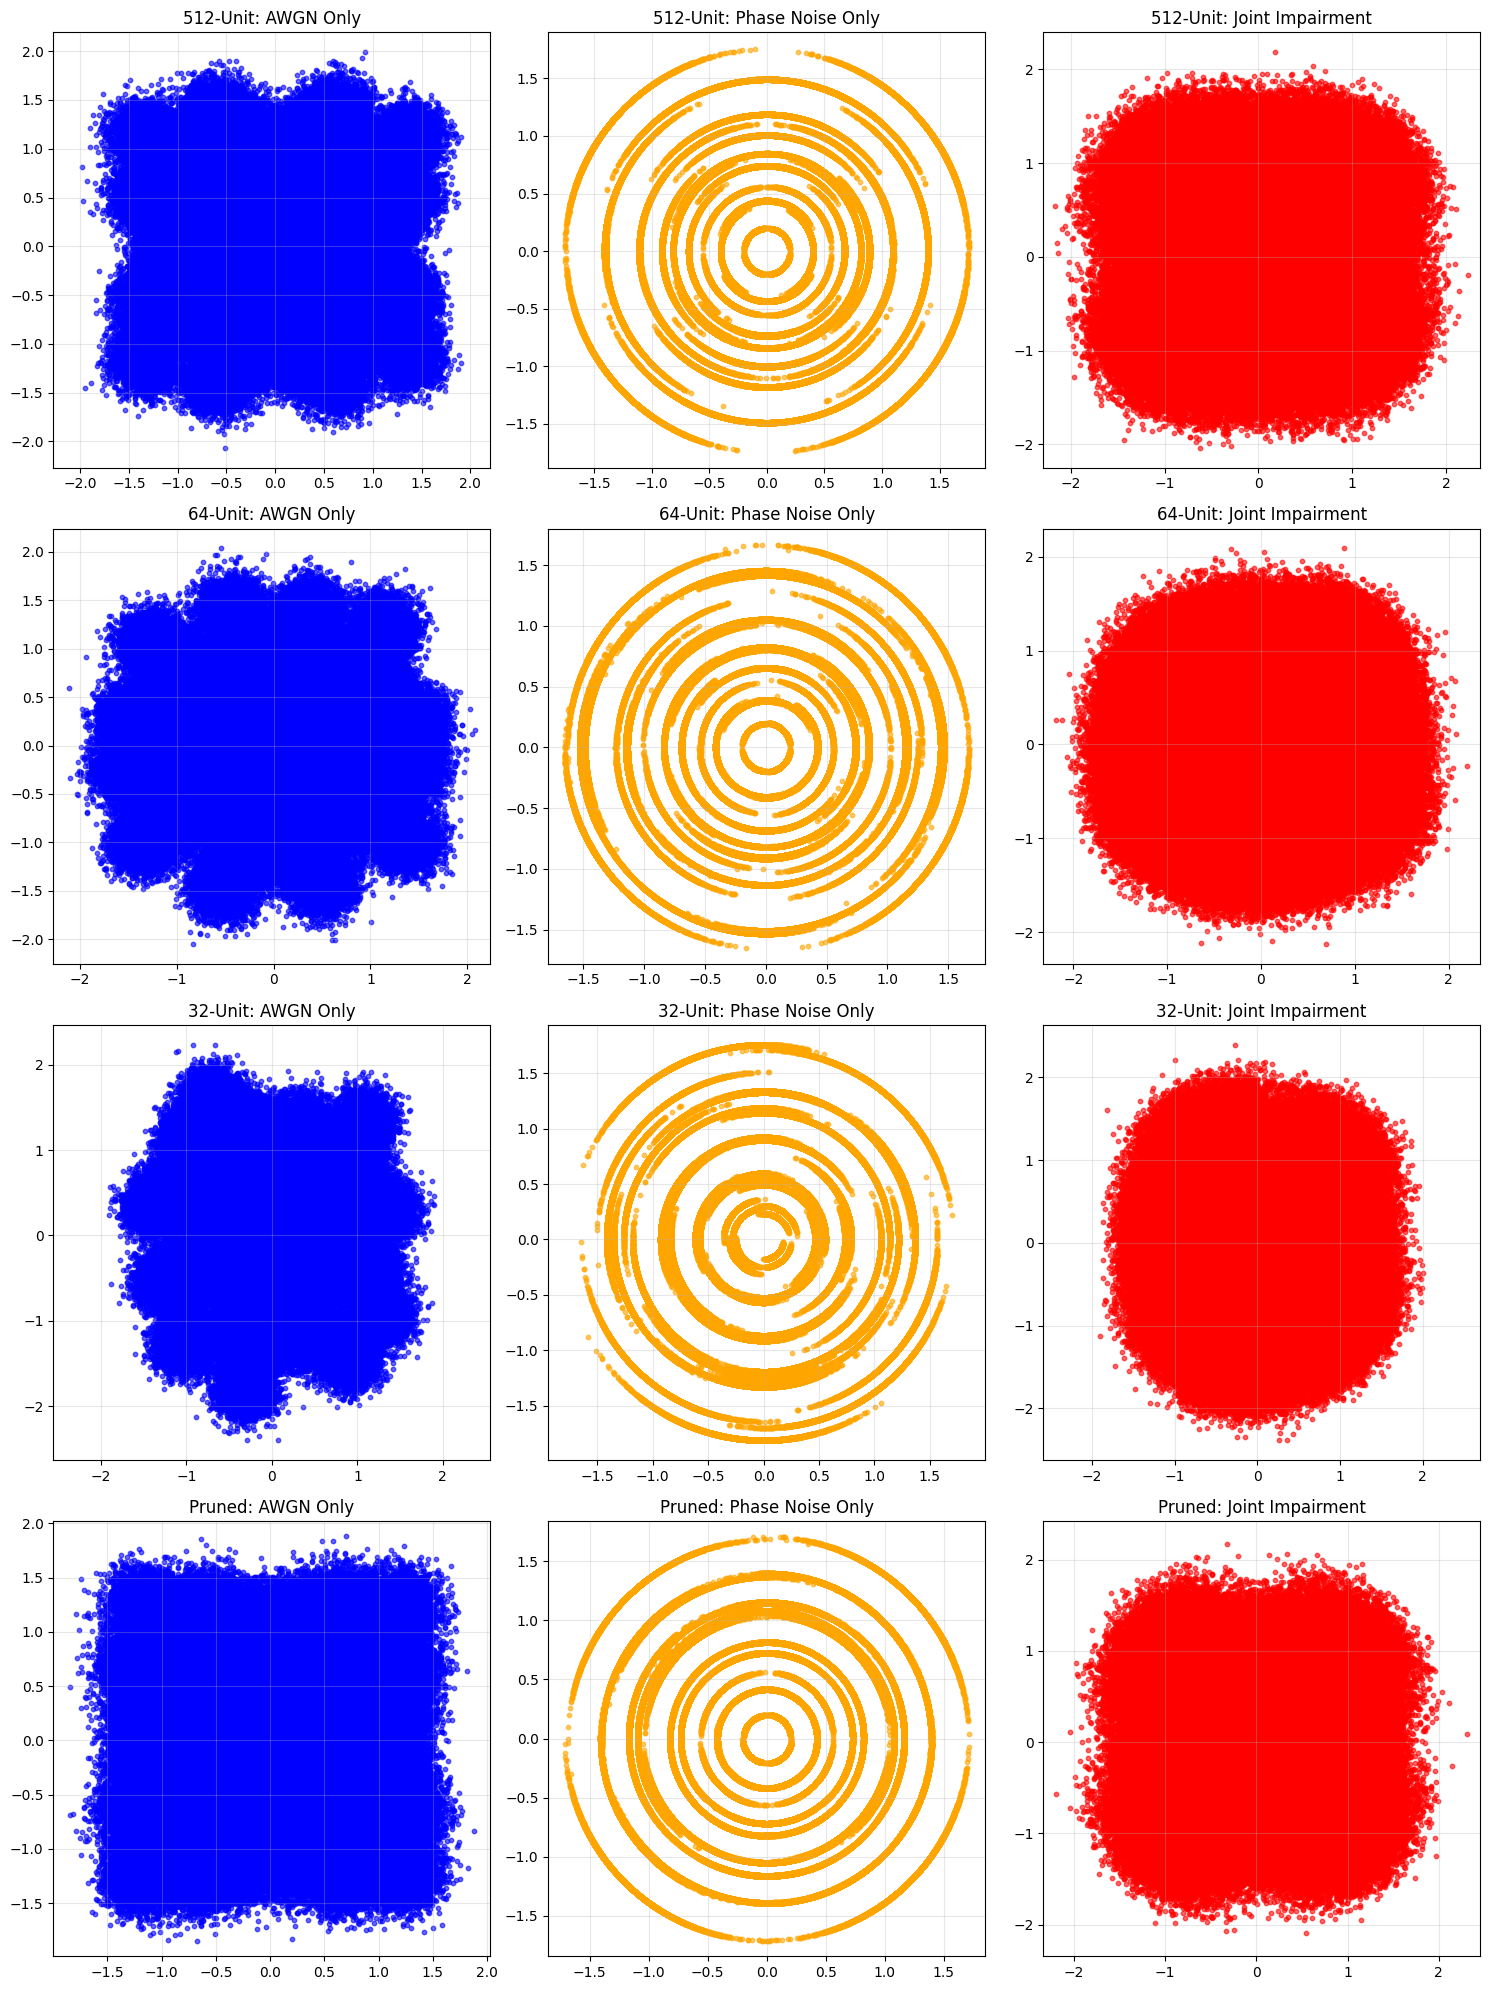

In [113]:
# Plot constellation stages for different models
print("Plotting constellation stages...")

# For conventional model (512-unit)
plot_constellation_stages(model_conventional_eval, ebno_db=8,
                         title_prefix="512-Unit: ")

# For 64-unit model
plot_constellation_stages(model_64unit_eval, ebno_db=8,
                         title_prefix="64-Unit: ")

# For 32-unit model
plot_constellation_stages(model_32unit_eval, ebno_db=8,
                         title_prefix="32-Unit: ")
# For pruned model
plot_constellation_stages(model_pruned_eval, ebno_db=8,
                         title_prefix="Pruned: ")


# Compare all models
models_to_compare = {
    '512-Unit': model_conventional_eval,
    '64-Unit': model_64unit_eval,
    '32-Unit': model_32unit_eval,
    'Pruned': model_pruned_eval
}

plot_multi_model_comparison(models_to_compare, ebno_db=8)


## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.